# <center> Customer Segmentation Using RFM <center>

## Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

## Set visualization style and display options

In [2]:
plt.style.use('ggplot')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Configure plot sizes for better display in Jupyter notebook

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size for notebook display

## Load the dataset

In [50]:
print("Step 1: Loading the dataset...")
df = pd.read_csv('rfm_data_orders.rda.csv')
print(f"✓ Successfully loaded dataset with shape: {df.shape}")

Step 1: Loading the dataset...
✓ Successfully loaded dataset with shape: (4906, 7)


## Display basic information

In [5]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,Unnamed: 0,customer_id,order_date,revenue,first_name,last_name,email
0,0,Brion Stark,2004-12-20,32,Brion,Stark,brion_stark@rfmail.com
1,1,Ethyl Botsford,2005-05-02,36,Ethyl,Botsford,ethyl_botsford@rfmail.com
2,2,Hosteen Jacobi,2004-03-06,116,Hosteen,Jacobi,hosteen_jacobi@rfmail.com
3,3,Edw Frami,2006-03-15,99,Edw,Frami,edw_frami@rfmail.com
4,4,Josef Lemke,2006-08-14,76,Josef,Lemke,josef_lemke@rfmail.com


## DATA CLEANING SECTION

In [6]:
print("\nStep 2: Data Cleaning and Preprocessing...")


Step 2: Data Cleaning and Preprocessing...


## I. Fix column names if needed

In [7]:
if '' in df.columns:
    print("Found empty column name, renaming to 'index'")
    df = df.rename(columns={'': 'index'})
elif 'Unnamed: 0' in df.columns:
    print("Found 'Unnamed: 0' column, renaming to 'index'")
    df = df.rename(columns={'Unnamed: 0': 'index'})

Found 'Unnamed: 0' column, renaming to 'index'


## II. Convert order_date to datetime

In [8]:
df['order_date'] = pd.to_datetime(df['order_date'])
print("✓ Converted order_date to datetime format")

✓ Converted order_date to datetime format


## Add year and month columns for analysis

In [9]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['year_month'] = df['order_date'].dt.strftime('%Y-%m')

## Analyze distribution by year

In [10]:
year_counts = df['year'].value_counts().sort_index()
print("\nOrder count by year:")
display(year_counts)


Order count by year:


year
2001       1
2004    1510
2005    2342
2006    1053
Name: count, dtype: int64

## Check for early year outliers and filter if necessary

In [11]:
early_years = [year for year in year_counts.index if year < 2004]
if early_years:
    print(f"\nFound orders in early years: {early_years}")
    # Filter out early years
    df = df[df['year'] >= 2004].copy()
    print(f"Filtered dataset shape: {df.shape}")


Found orders in early years: [2001]
Filtered dataset shape: (4905, 10)


## III. Keep only necessary columns

In [12]:
columns_to_keep = ['customer_id', 'order_date', 'revenue']
clean_df = df[columns_to_keep].copy()
print(f"Kept columns: {clean_df.columns.tolist()}")

Kept columns: ['customer_id', 'order_date', 'revenue']


## IV. Check for missing values and duplicates

In [13]:
missing_values = clean_df.isnull().sum()
print("Missing values per column:")
display(missing_values)

if missing_values.sum() > 0:
    # Handle missing values
    if clean_df['revenue'].isnull().sum() > 0:
        clean_df['revenue'].fillna(clean_df['revenue'].median(), inplace=True)
    if clean_df['order_date'].isnull().sum() > 0:
        clean_df.dropna(subset=['order_date'], inplace=True)
    print("Missing values after handling:")
    display(clean_df.isnull().sum())
else:
    print("✓ No missing values found")

Missing values per column:


customer_id    0
order_date     0
revenue        0
dtype: int64

✓ No missing values found


## Check for duplicate records

In [14]:
duplicate_count = clean_df.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")
if duplicate_count > 0:
    clean_df.drop_duplicates(inplace=True)
    print(f"✓ Removed {duplicate_count} duplicates")

Number of duplicate records: 0


## V. Revenue Outlier Detection

In [15]:
print("\nStep 2.5: Detecting outliers in revenue...")
revenue_stats = clean_df['revenue'].describe()
print("Revenue statistics:")
display(revenue_stats)


Step 2.5: Detecting outliers in revenue...
Revenue statistics:


count   4905.00
mean      94.59
std       57.82
min       10.00
25%       45.00
50%       81.00
75%      137.00
max      219.00
Name: revenue, dtype: float64

## Distribution of revenue

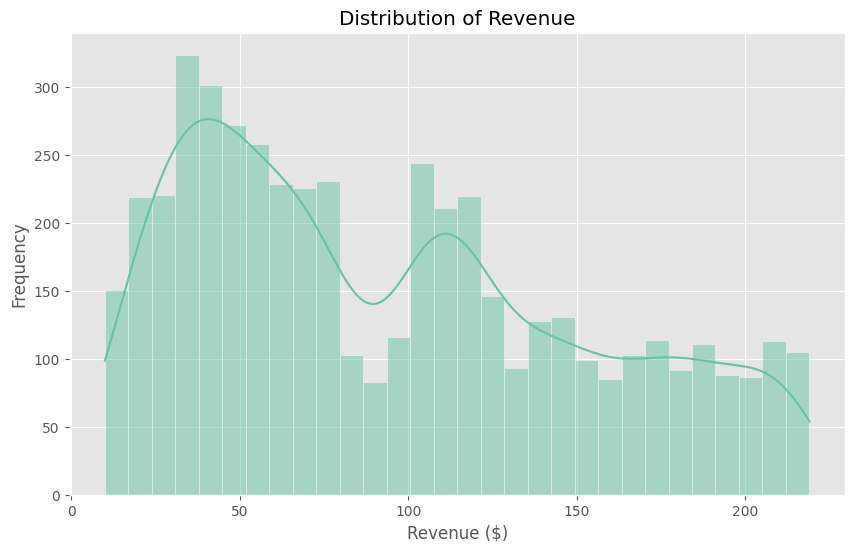

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['revenue'], bins=30, kde=True)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.show()

## Box plot for revenue

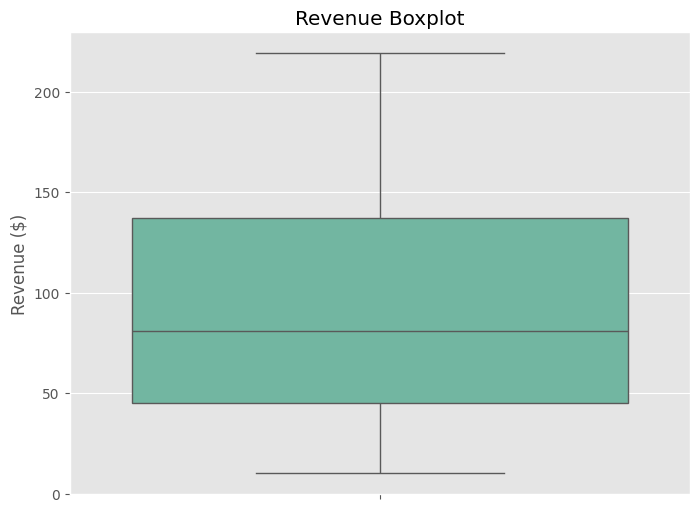

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=clean_df['revenue'])
plt.title('Revenue Boxplot')
plt.ylabel('Revenue ($)')
plt.show()

## Use IQR method for outlier detection

In [18]:
Q1 = revenue_stats['25%']
Q3 = revenue_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = clean_df[(clean_df['revenue'] < lower_bound) | (clean_df['revenue'] > upper_bound)]
print(f"Potential revenue outliers (IQR method): {len(outliers_iqr)} records")
print(f"Percentage of data as outliers: {len(outliers_iqr) / len(clean_df) * 100:.2f}%")


Potential revenue outliers (IQR method): 0 records
Percentage of data as outliers: 0.00%


In [19]:
# Decision about revenue outliers (keeping them for now)
print("\nKeeping revenue outliers as they likely represent genuine high-value orders.")

# VISUALIZATIONS AND ANALYSIS
print("\nStep 3: Visualizations and Analysis...")


Keeping revenue outliers as they likely represent genuine high-value orders.

Step 3: Visualizations and Analysis...


## Add date-related fields for analysis

In [20]:
clean_df['order_month'] = clean_df['order_date'].dt.month
clean_df['order_year'] = clean_df['order_date'].dt.year
clean_df['year_month'] = clean_df['order_date'].dt.strftime('%Y-%m')

## Calculate key business metrics

In [21]:
total_revenue = clean_df['revenue'].sum()
total_orders = len(clean_df)
unique_customers = clean_df['customer_id'].nunique()
avg_order_value = total_revenue / total_orders
avg_orders_per_customer = total_orders / unique_customers
avg_revenue_per_customer = total_revenue / unique_customers

print("\nKey Business Metrics:")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Number of Orders: {total_orders:,}")
print(f"Number of Unique Customers: {unique_customers:,}")
print(f"Average Order Value: ${avg_order_value:.2f}")
print(f"Average Orders per Customer: {avg_orders_per_customer:.2f}")
print(f"Average Revenue per Customer: ${avg_revenue_per_customer:.2f}")


Key Business Metrics:
Total Revenue: $463,980.00
Number of Orders: 4,905
Number of Unique Customers: 995
Average Order Value: $94.59
Average Orders per Customer: 4.93
Average Revenue per Customer: $466.31


# <center> VISUALIZATION <center>

## 1. Revenue Distribution Chart

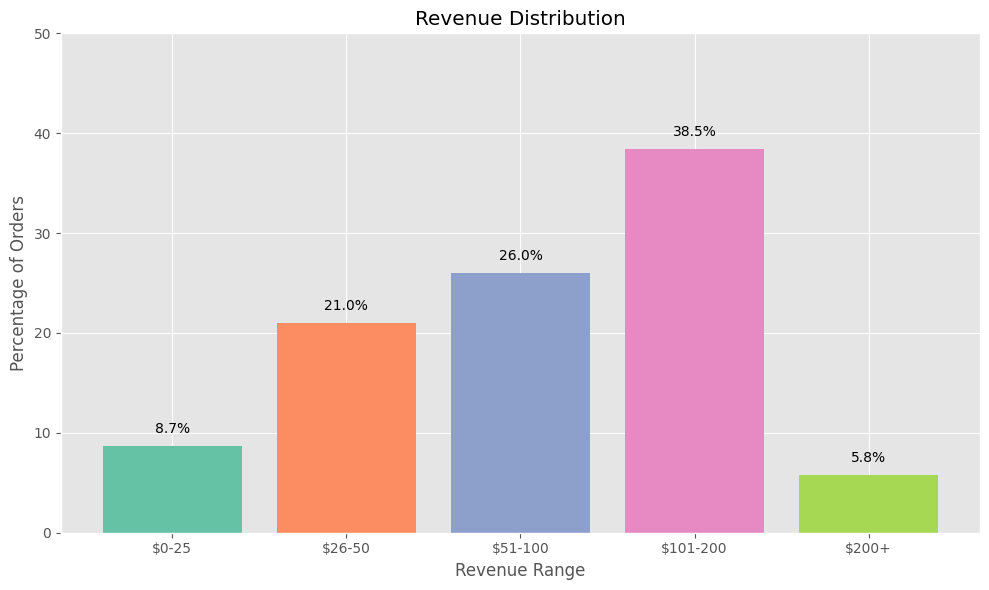

In [22]:
revenue_bins = [0, 25, 50, 100, 200, clean_df['revenue'].max()]
revenue_labels = ['$0-25', '$26-50', '$51-100', '$101-200', '$200+']
clean_df['revenue_category'] = pd.cut(clean_df['revenue'], bins=revenue_bins, labels=revenue_labels)

revenue_distribution = clean_df['revenue_category'].value_counts().sort_index()
revenue_percentage = revenue_distribution / len(clean_df) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_percentage.index, revenue_percentage.values, color=sns.color_palette("Set2"))
plt.title('Revenue Distribution')
plt.xlabel('Revenue Range')
plt.ylabel('Percentage of Orders')
plt.ylim(0, 50)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 2. Monthly Trends Chart

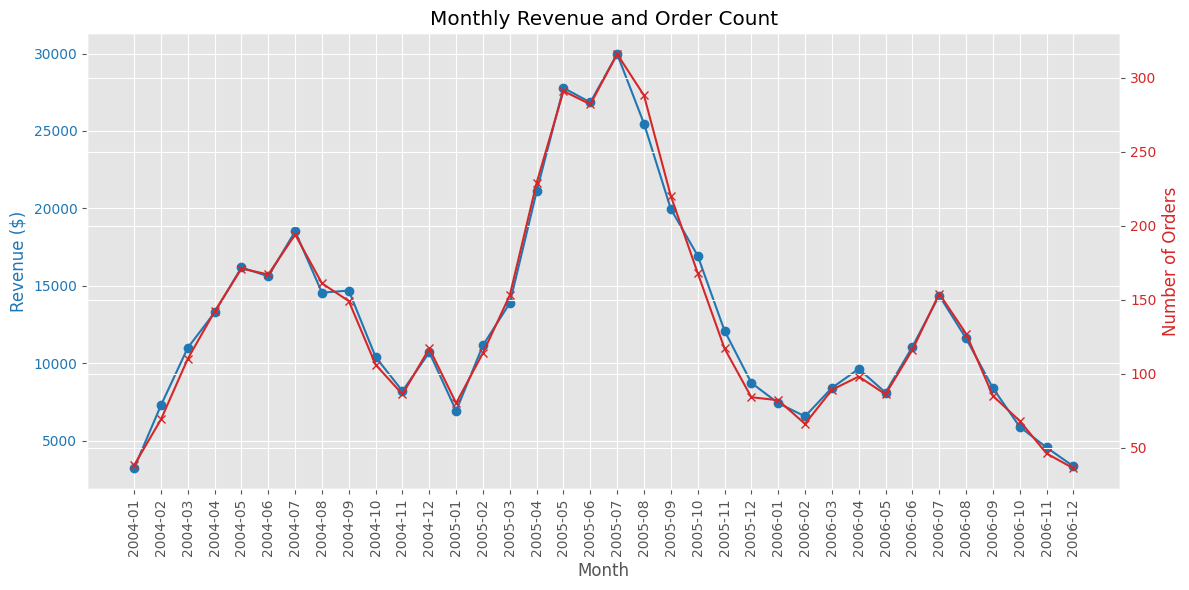

In [23]:
monthly_data = clean_df.groupby('year_month').agg(
    Revenue=('revenue', 'sum'),
    Orders=('customer_id', 'count')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue ($)', color='tab:blue')
ax1.plot(monthly_data['year_month'], monthly_data['Revenue'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=90)

# Plot order count on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Orders', color='tab:red')
ax2.plot(monthly_data['year_month'], monthly_data['Orders'], color='tab:red', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Monthly Revenue and Order Count')
fig.tight_layout()
plt.show()

## 3. RFM Analysis

In [24]:
print("\nStep 4: Performing RFM Analysis...")

# Set the reference date to the most recent order date in the dataset
reference_date = clean_df['order_date'].max()
print(f"Reference date for RFM analysis: {reference_date}")



Step 4: Performing RFM Analysis...
Reference date for RFM analysis: 2006-12-30 00:00:00


## Calculate RFM metrics

In [25]:
rfm = clean_df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'customer_id': 'count',  # Frequency
    'revenue': 'sum'  # Monetary
})

# Rename the columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM metrics summary
print("\nRFM Metrics Summary:")
display(rfm.describe())


RFM Metrics Summary:


,Recency,Frequency,Monetary
count,995.00,995.00,995.00
mean,285.74,4.93,466.31
std,194.49,2.21,240.81
min,0.00,1.00,12.00
25%,131.00,3.00,284.50
50%,228.00,5.00,436.00
75%,444.50,6.00,620.00
max,975.00,14.00,1488.00


## Visualize the distribution of RFM metrics

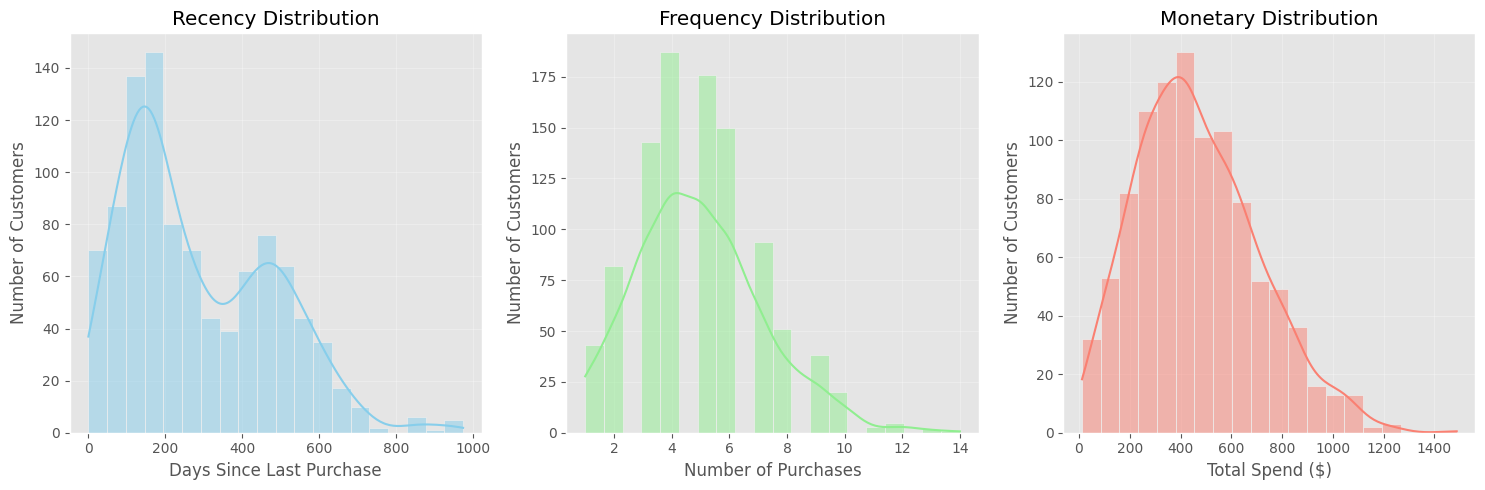

In [26]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recency distribution
sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')
axes[0].grid(True, alpha=0.3)

# Frequency distribution
sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')
axes[1].grid(True, alpha=0.3)

# Monetary distribution
sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Spend ($)')
axes[2].set_ylabel('Number of Customers')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Create RFM quintiles

In [27]:
# Create RFM quintiles
try:
    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
except ValueError:
    print("Handling ties in recency values...")
    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    if len(rfm['R_Score'].dropna()) < len(rfm):
        rfm['R_rank'] = rfm['Recency'].rank(ascending=False)
        rfm['R_Score'] = pd.qcut(rfm['R_rank'], q=5, labels=[5, 4, 3, 2, 1])

try:
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=5, labels=[1, 2, 3, 4, 5])
except ValueError:
    print("Handling ties in frequency values...")
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
    if len(rfm['F_Score'].dropna()) < len(rfm):
        rfm['F_rank'] = rfm['Frequency'].rank(ascending=True)
        rfm['F_Score'] = pd.qcut(rfm['F_rank'], q=5, labels=[1, 2, 3, 4, 5])

try:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])
except ValueError:
    print("Handling ties in monetary values...")
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
    if len(rfm['M_Score'].dropna()) < len(rfm):
        rfm['M_rank'] = rfm['Monetary'].rank(ascending=True)
        rfm['M_Score'] = pd.qcut(rfm['M_rank'], q=5, labels=[1, 2, 3, 4, 5])

# Convert quintile values to integers for calculations
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate overall RFM Score
rfm['RFM_Score'] = rfm['R_Score'] * 100 + rfm['F_Score'] * 10 + rfm['M_Score']

# Display RFM scores
print("\nRFM Scores (first 10 customers):")
display(rfm[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head(10))


RFM Scores (first 10 customers):


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
Abbey O'Reilly,204,6,472,3,4,3,343
Add Senger,139,3,340,4,1,2,412
Aden Lesch,193,4,405,3,2,3,323
Aden Murphy,97,7,596,5,4,4,544
Admiral Senger,131,5,448,4,3,3,433
Agness O'Keefe,89,9,843,5,5,5,555
Aileen Barton,83,9,763,5,5,5,555
Ailene Hermann,280,8,699,3,5,5,355
Aiyanna Bruen,245,4,157,3,2,1,321


In [28]:
# Define customer segments
def classify_customer(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif 2 <= r <= 4 and 3 <= f <= 4 and 4 <= m <= 5:
        return "Loyal Customers"
    elif 3 <= r <= 5 and 1 <= f <= 3 and 1 <= m <= 3:
        return "Potential Loyalist"
    elif r >= 4 and f < 2 and m < 2:
        return "New Customers"
    elif 3 <= r <= 4 and f < 2 and m < 2:
        return "Promising"
    elif 3 <= r <= 4 and 3 <= f <= 4 and 3 <= m <= 4:
        return "Need Attention"
    elif 2 <= r <= 3 and f < 3 and m < 3:
        return "About To Sleep"
    elif r < 3 and 2 <= f <= 5 and 2 <= m <= 5:
        return "At Risk"
    elif r < 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    elif 2 <= r <= 3 and 2 <= f <= 3 and 2 <= m <= 3:
        return "Hibernating"
    elif r < 2 and f < 2 and m < 2:
        return "Lost"
    elif r >= 3 and (f >= 2 or m >= 3):
        return "Active Moderate Buyers"
    elif r < 3 and (f >= 3 or m >= 3):
        return "Inactive High Value"
    elif 2 <= r < 4 and 2 <= f < 4 and 2 <= m < 4:
        return "Mid-Value Regular"
    else:
        return "Other"

## Apply the segmentation function

In [29]:
rfm['Segment'] = rfm.apply(classify_customer, axis=1)

## Display segmentation results

In [30]:
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
segment_counts['Percentage'] = segment_counts['Count'] / segment_counts['Count'].sum() * 100

print("\nCustomer Segment Distribution:")
display(segment_counts.sort_values('Count', ascending=False))

# Reset the index to get customer_id as a column
rfm_reset = rfm.reset_index()


Customer Segment Distribution:


,Segment,Count,Percentage
0,Potential Loyalist,277,27.84
1,Champions,159,15.98
2,At Risk,148,14.87
3,Loyal Customers,126,12.66
4,Active Moderate Buyers,77,7.74
5,Lost,76,7.64
6,About To Sleep,65,6.53
7,Other,35,3.52
8,Need Attention,17,1.71
9,Inactive High Value,15,1.51


## 4. Segment Distribution Chart

In [31]:
plt.figure(figsize=(12, 8))
segment_plot = segment_counts.sort_values('Count', ascending=False)
# Additional RFM Outlier Detection
print("\nStep 4.1: Detecting outliers in RFM metrics...")

# After calculating RFM but before scoring
# First, let's examine the distribution of each RFM metric
print("\nRFM metrics distribution statistics:")
display(rfm[['Recency', 'Frequency', 'Monetary']].describe())


Step 4.1: Detecting outliers in RFM metrics...

RFM metrics distribution statistics:


,Recency,Frequency,Monetary
count,995.00,995.00,995.00
mean,285.74,4.93,466.31
std,194.49,2.21,240.81
min,0.00,1.00,12.00
25%,131.00,3.00,284.50
50%,228.00,5.00,436.00
75%,444.50,6.00,620.00
max,975.00,14.00,1488.00


<Figure size 1200x800 with 0 Axes>

## Visualize boxplots for each RFM metric to identify outliers

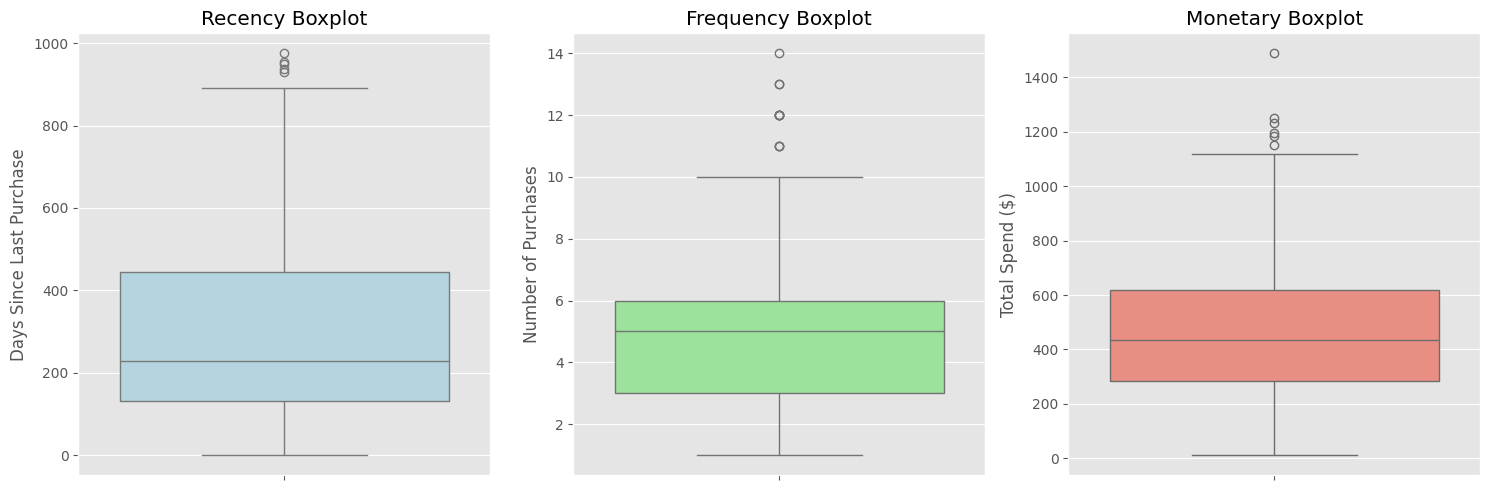

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(y=rfm['Recency'], ax=axes[0], color='lightblue')
axes[0].set_title('Recency Boxplot')
axes[0].set_ylabel('Days Since Last Purchase')

sns.boxplot(y=rfm['Frequency'], ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency Boxplot')
axes[1].set_ylabel('Number of Purchases')

sns.boxplot(y=rfm['Monetary'], ax=axes[2], color='salmon')
axes[2].set_title('Monetary Boxplot')
axes[2].set_ylabel('Total Spend ($)')

plt.tight_layout()
plt.show()

## Use IQR method to detect outliers in each RFM metric

In [33]:
def detect_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for each RFM metric
recency_outliers, r_lower, r_upper = detect_iqr_outliers(rfm, 'Recency')
frequency_outliers, f_lower, f_upper = detect_iqr_outliers(rfm, 'Frequency')
monetary_outliers, m_lower, m_upper = detect_iqr_outliers(rfm, 'Monetary')

print(f"\nRecency outliers: {len(recency_outliers)} ({len(recency_outliers)/len(rfm)*100:.2f}%)")
print(f"Bounds: {r_lower:.2f} to {r_upper:.2f} days")

print(f"\nFrequency outliers: {len(frequency_outliers)} ({len(frequency_outliers)/len(rfm)*100:.2f}%)")
print(f"Bounds: {f_lower:.2f} to {f_upper:.2f} purchases")

print(f"\nMonetary outliers: {len(monetary_outliers)} ({len(monetary_outliers)/len(rfm)*100:.2f}%)")
print(f"Bounds: ${m_lower:.2f} to ${m_upper:.2f}")


Recency outliers: 5 (0.50%)
Bounds: -339.25 to 914.75 days

Frequency outliers: 11 (1.11%)
Bounds: -1.50 to 10.50 purchases

Monetary outliers: 6 (0.60%)
Bounds: $-218.75 to $1123.25


## Examine extreme RFM values

In [34]:
print("\nTop 5 extreme values in each RFM metric:")
print("\nHighest Recency (customers who haven't purchased in a long time):")
display(rfm.nlargest(5, 'Recency')[['Recency', 'Frequency', 'Monetary']])

print("\nHighest Frequency (customers with most purchases):")
display(rfm.nlargest(5, 'Frequency')[['Recency', 'Frequency', 'Monetary']])

print("\nHighest Monetary Value (highest spending customers):")
display(rfm.nlargest(5, 'Monetary')[['Recency', 'Frequency', 'Monetary']])


Top 5 extreme values in each RFM metric:

Highest Recency (customers who haven't purchased in a long time):


,Recency,Frequency,Monetary
customer_id,,,
Lionel Marquardt,975,1,133
Link Orn,954,1,61
Dandre Nolan,950,1,30
Angeles McLaughlin,936,1,138
Azul Wehner,931,1,190



Highest Frequency (customers with most purchases):


,Recency,Frequency,Monetary
customer_id,,,
Lary Champlin,123,14,1074
Isabela Mertz,96,13,1104
Kizzy Doyle,167,13,1488
Delpha King,42,12,1233
Elmyra Schaefer,325,12,1150



Highest Monetary Value (highest spending customers):


,Recency,Frequency,Monetary
customer_id,,,
Kizzy Doyle,167,13,1488
Dominik Anderson,19,10,1249
Delpha King,42,12,1233
Zechariah Gislason,206,9,1196
Tad Johnson,205,10,1184


## Decision on handling RFM outliers

In [35]:
print("\nRFM Outlier Handling Decision:")

# Option 1: Keep outliers (default approach in RFM analysis)
print("Keeping RFM outliers in the analysis for the following reasons:")
print("- Extreme values in RFM are often legitimate and represent valuable high/low customer behavior")
print("- The quantile-based scoring approach (1-5) mitigates the impact of outliers by grouping them")
print("- Customers with extreme values often represent important segments (e.g., high-value customers)")

# Option 2: If you decide to cap outliers, you can use code like this:
"""
# Cap extreme values to reduce their influence
rfm_capped = rfm.copy()

# Cap Recency outliers
rfm_capped['Recency'] = rfm_capped['Recency'].clip(lower=r_lower, upper=r_upper)

# Cap Frequency outliers
rfm_capped['Frequency'] = rfm_capped['Frequency'].clip(lower=f_lower, upper=f_upper)

# Cap Monetary outliers
rfm_capped['Monetary'] = rfm_capped['Monetary'].clip(lower=m_lower, upper=m_upper)

print("Created capped version of RFM metrics to reduce outlier influence")
"""



RFM Outlier Handling Decision:
Keeping RFM outliers in the analysis for the following reasons:
- Extreme values in RFM are often legitimate and represent valuable high/low customer behavior
- The quantile-based scoring approach (1-5) mitigates the impact of outliers by grouping them
- Customers with extreme values often represent important segments (e.g., high-value customers)


'\n# Cap extreme values to reduce their influence\nrfm_capped = rfm.copy()\n\n# Cap Recency outliers\nrfm_capped[\'Recency\'] = rfm_capped[\'Recency\'].clip(lower=r_lower, upper=r_upper)\n\n# Cap Frequency outliers\nrfm_capped[\'Frequency\'] = rfm_capped[\'Frequency\'].clip(lower=f_lower, upper=f_upper)\n\n# Cap Monetary outliers\nrfm_capped[\'Monetary\'] = rfm_capped[\'Monetary\'].clip(lower=m_lower, upper=m_upper)\n\nprint("Created capped version of RFM metrics to reduce outlier influence")\n'

## Assess impact of outliers on segmentation

In [36]:
all_outliers = rfm[(rfm.index.isin(recency_outliers.index)) | 
                   (rfm.index.isin(frequency_outliers.index)) | 
                   (rfm.index.isin(monetary_outliers.index))]

print(f"\nNumber of customers with at least one outlier RFM metric: {len(all_outliers)} ({len(all_outliers)/len(rfm)*100:.2f}%)")


Number of customers with at least one outlier RFM metric: 19 (1.91%)


## Visualize outliers in a 3D scatter plot (if you prefer this visualization)

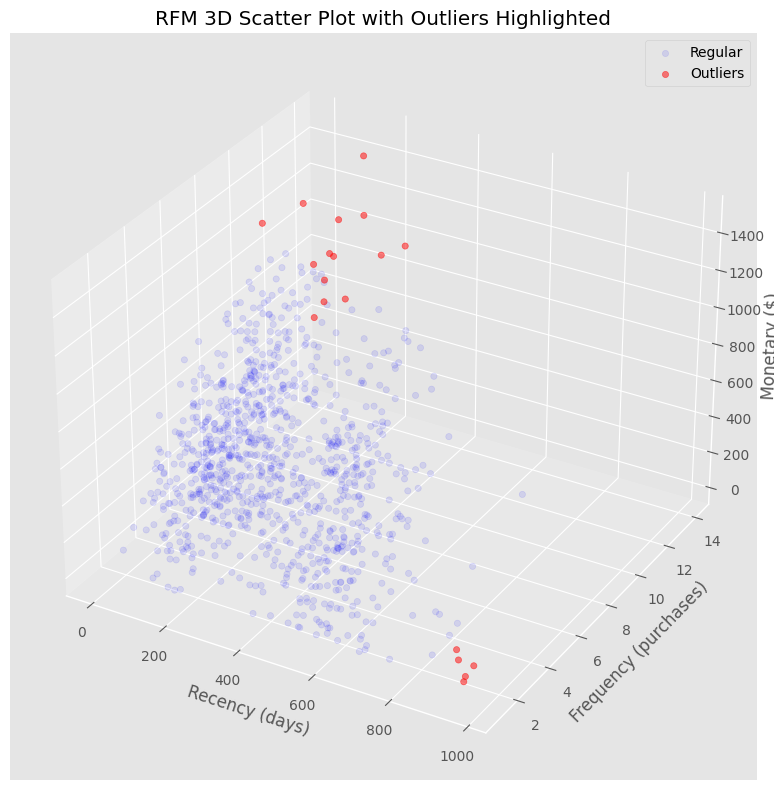

In [37]:

try:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot regular points
    regular = rfm[~rfm.index.isin(all_outliers.index)]
    ax.scatter(regular['Recency'], regular['Frequency'], regular['Monetary'], 
               c='blue', marker='o', alpha=0.1, label='Regular')
    
    # Plot outlier points
    ax.scatter(all_outliers['Recency'], all_outliers['Frequency'], all_outliers['Monetary'], 
               c='red', marker='o', alpha=0.5, label='Outliers')
    
    ax.set_xlabel('Recency (days)')
    ax.set_ylabel('Frequency (purchases)')
    ax.set_zlabel('Monetary ($)')
    ax.set_title('RFM 3D Scatter Plot with Outliers Highlighted')
    plt.legend()
    plt.tight_layout()
    plt.show()
except:
    print("3D plotting requires mpl_toolkits.mplot3d which might not be available.")
    
    # Alternative 2D visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(rfm['Recency'], rfm['Frequency'], 
                c=rfm['Monetary'], cmap='viridis', alpha=0.5)
    plt.colorbar(label='Monetary Value ($)')
    
    # Highlight outliers
    plt.scatter(all_outliers['Recency'], all_outliers['Frequency'], 
                s=50, facecolors='none', edgecolors='red', 
                label='Outliers')
    
    plt.title('RFM Scatter Plot with Outliers Highlighted')
    plt.xlabel('Recency (days)')
    plt.ylabel('Frequency (purchases)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Create a custom color palette

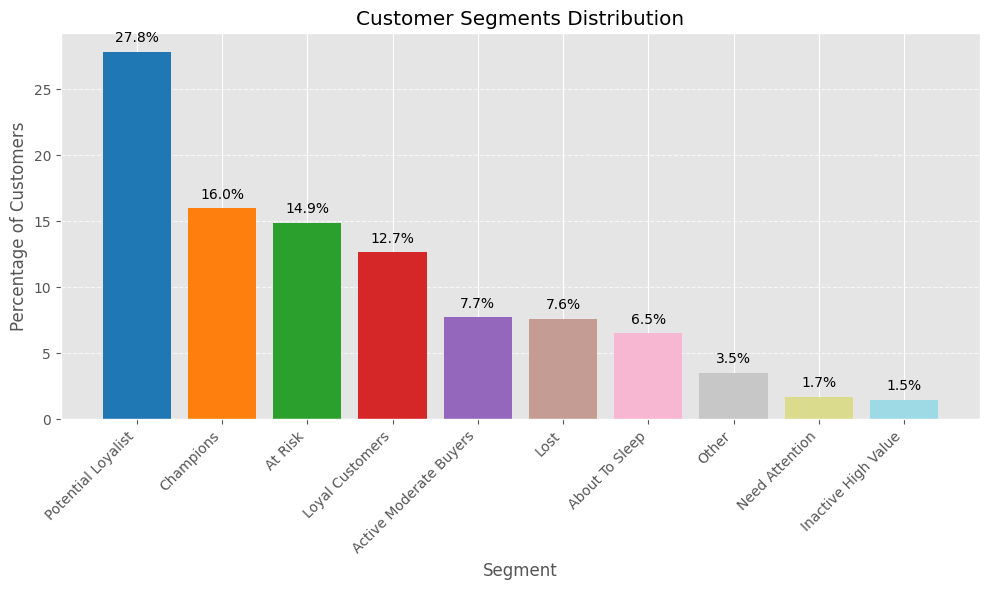

In [38]:
colors = plt.cm.tab20(np.linspace(0, 1, len(segment_plot)))

bars = plt.bar(segment_plot['Segment'], segment_plot['Percentage'], color=colors)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Calculate segment metrics and show monetary by segment

In [39]:
segment_metrics = rfm_reset.groupby('Segment').agg({
    'Recency': 'median',
    'Frequency': 'median',
    'Monetary': 'median',
    'RFM_Score': 'mean',
    'customer_id': 'count'
}).reset_index()

segment_metrics = segment_metrics.sort_values('Monetary', ascending=False)
print("\nSegment Metrics:")
display(segment_metrics)


Segment Metrics:


,Segment,Recency,Frequency,Monetary,RFM_Score,customer_id
3,Champions,115.00,7.00,744.00,499.11,159
6,Loyal Customers,279.00,6.00,627.50,301.67,126
1,Active Moderate Buyers,141.00,6.00,538.00,444.71,77
2,At Risk,484.00,5.00,489.50,183.57,148
4,Inactive High Value,516.00,3.00,455.00,153.20,15
7,Need Attention,167.00,6.00,448.00,395.94,17
9,Potential Loyalist,156.00,4.00,323.00,415.85,277
8,Other,545.00,3.00,295.00,113.80,35
0,About To Sleep,398.00,3.00,260.00,214.15,65
5,Lost,587.00,2.00,133.00,111.00,76


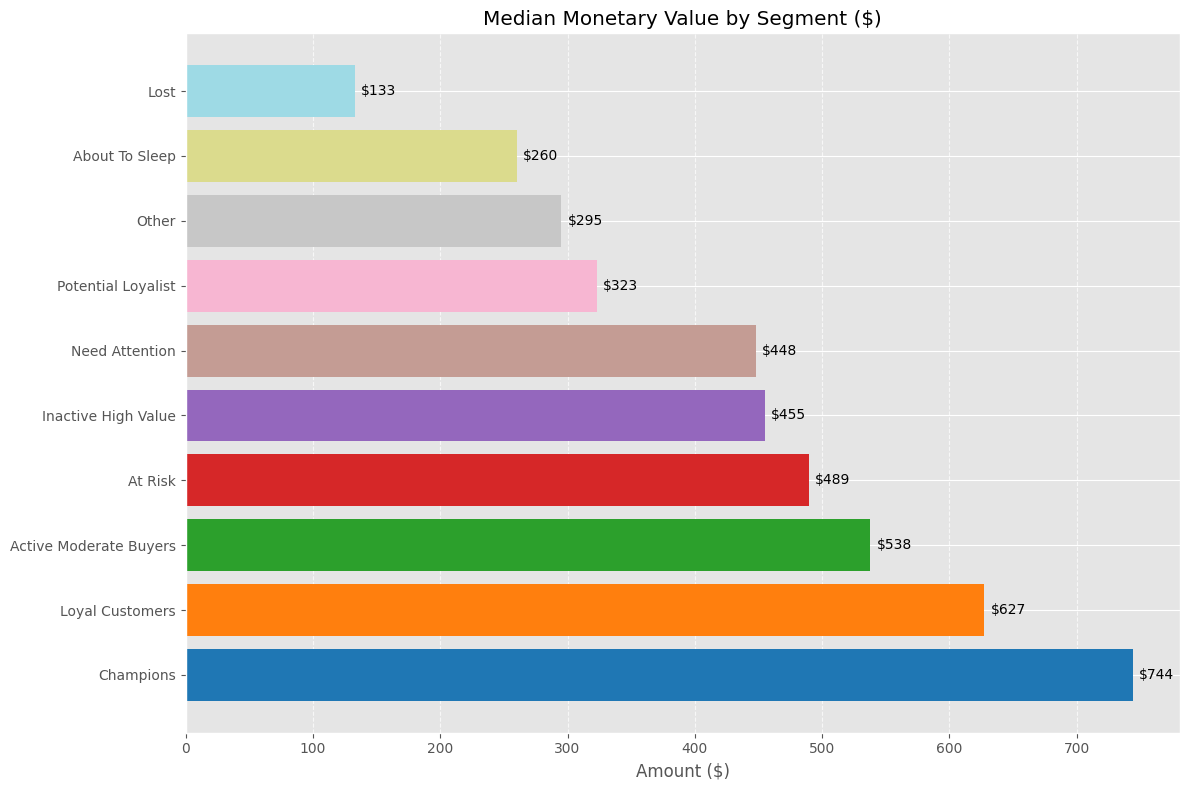

In [40]:
plt.figure(figsize=(12, 8))
bars = plt.barh(segment_metrics['Segment'], segment_metrics['Monetary'], color=colors[:len(segment_metrics)])
plt.title('Median Monetary Value by Segment ($)')
plt.xlabel('Amount ($)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, f'${int(width)}', 
             ha='left', va='center')

plt.tight_layout()
plt.show()


## 6. RFM Heatmap

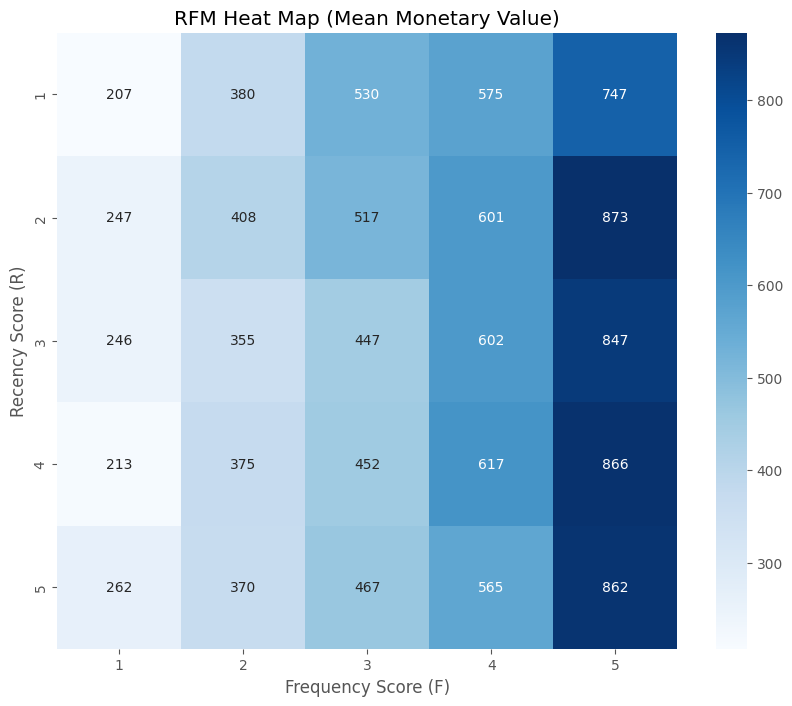

In [41]:
try:
    rfm_heatmap = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean')
    plt.figure(figsize=(10, 8))
    sns.heatmap(rfm_heatmap, cmap='Blues', annot=True, fmt=".0f")
    plt.title('RFM Heat Map (Mean Monetary Value)')
    plt.xlabel('Frequency Score (F)')
    plt.ylabel('Recency Score (R)')
    plt.show()
except:
    print("Could not create RFM heatmap due to missing combinations")


## 7. Churn Analysis

In [42]:
print("\nStep 5: Churn Analysis...")

# Define churn threshold (e.g., customers who haven't ordered in 180 days)
churn_threshold = 180  # days
print(f"Churn threshold: {churn_threshold} days of inactivity")


Step 5: Churn Analysis...
Churn threshold: 180 days of inactivity


## Classify customers as churned or active

In [43]:
customer_status = rfm_reset.copy()
customer_status['churned'] = customer_status['Recency'] > churn_threshold
customer_status['status'] = customer_status['churned'].map({True: 'Churned', False: 'Active'})

# Calculate overall churn rate
churn_rate = customer_status['churned'].mean() * 100
print(f"\nOverall Churn Rate: {churn_rate:.2f}%")
print(f"Active Customers: {(~customer_status['churned']).sum()} ({100-churn_rate:.2f}%)")
print(f"Churned Customers: {customer_status['churned'].sum()} ({churn_rate:.2f}%)")


Overall Churn Rate: 59.40%
Active Customers: 404 (40.60%)
Churned Customers: 591 (59.40%)


## Calculate churn rate by segment

In [44]:
segment_churn = customer_status.groupby('Segment').agg(
    total_customers=('customer_id', 'count'),
    churned_customers=('churned', 'sum')
).reset_index()

segment_churn['churn_rate'] = segment_churn['churned_customers'] / segment_churn['total_customers'] * 100
segment_churn['active_rate'] = 100 - segment_churn['churn_rate']
segment_churn = segment_churn.sort_values('churn_rate', ascending=False)

print("\nChurn Rate by Segment:")
display(segment_churn[['Segment', 'total_customers', 'churned_customers', 'churn_rate']])



Churn Rate by Segment:


,Segment,total_customers,churned_customers,churn_rate
0,About To Sleep,65,65,100.00
2,At Risk,148,148,100.00
4,Inactive High Value,15,15,100.00
5,Lost,76,76,100.00
8,Other,35,35,100.00
6,Loyal Customers,126,114,90.48
7,Need Attention,17,8,47.06
1,Active Moderate Buyers,77,30,38.96
9,Potential Loyalist,277,100,36.10
3,Champions,159,0,0.00


## 8. Churn by Segment Chart

In [45]:
plt.figure(figsize=(12, 8))
segment_plot = segment_churn.copy()


<Figure size 1200x800 with 0 Axes>

## Create a stacked bar chart

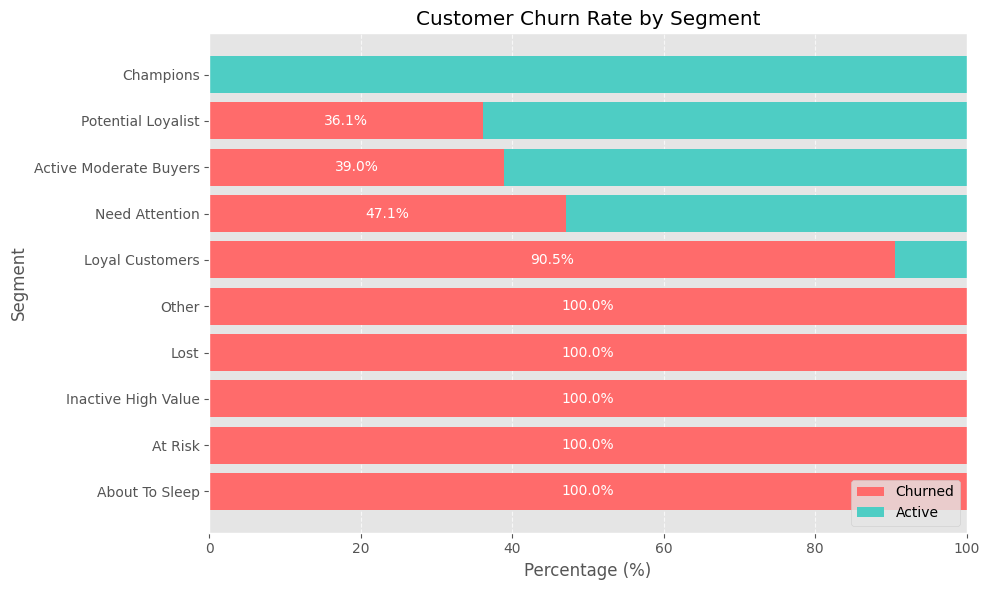

In [46]:
bars = plt.barh(segment_plot['Segment'], segment_plot['churn_rate'], 
                color='#FF6B6B', label='Churned')
plt.barh(segment_plot['Segment'], segment_plot['active_rate'], 
        left=segment_plot['churn_rate'], color='#4ECDC4', label='Active')

plt.title('Customer Churn Rate by Segment')
plt.xlabel('Percentage (%)')
plt.ylabel('Segment')
plt.xlim(0, 100)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', axis='x', alpha=0.7)

# Add percentage labels inside the churned bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 10:  # Only add label if there's enough space
        plt.text(width/2, bar.get_y() + bar.get_height()/2, 
                 f'{width:.1f}%', ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

## 9. Scatter plot of RFM dimensions

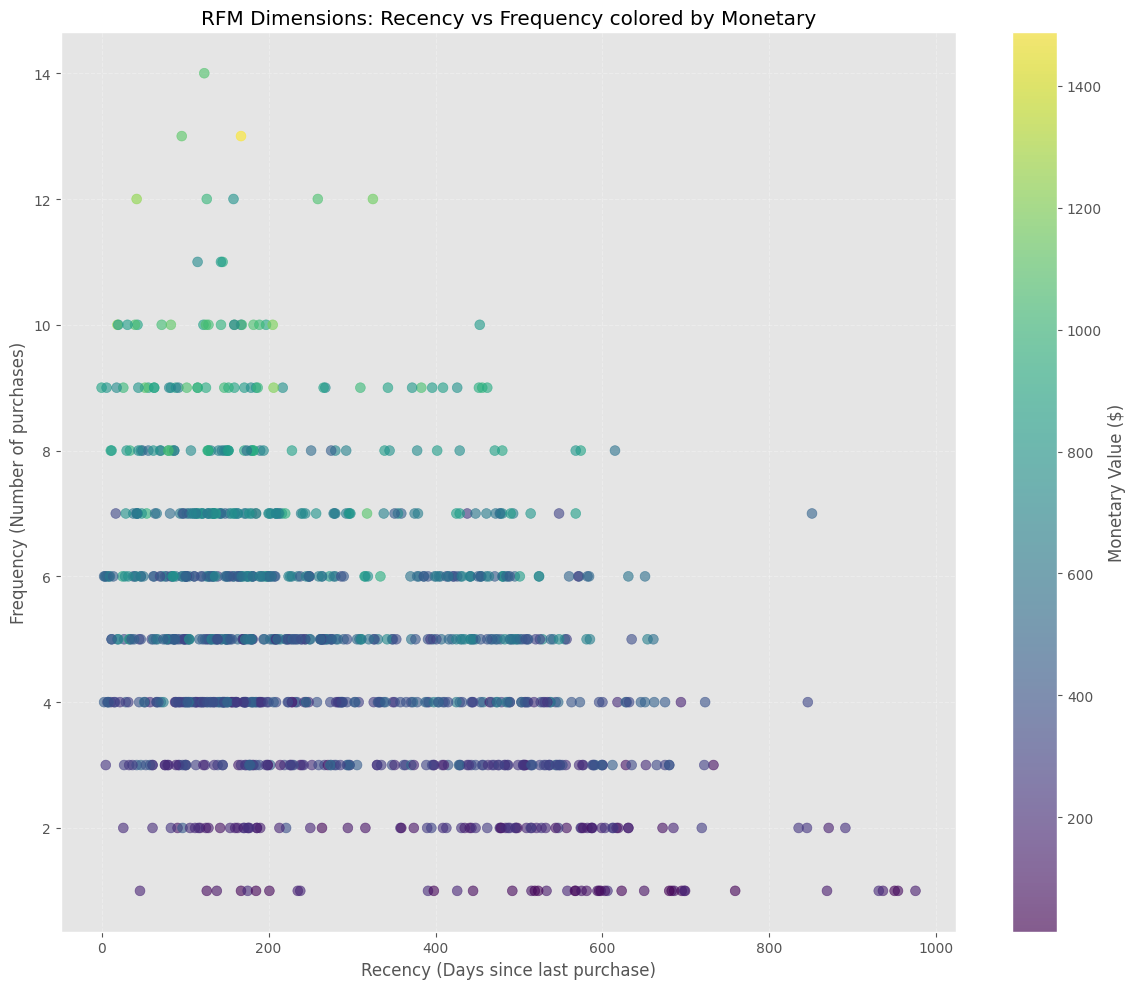

In [47]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(rfm['Recency'], rfm['Frequency'], 
                     c=rfm['Monetary'], cmap='viridis', 
                     alpha=0.6, s=50)
plt.colorbar(scatter, label='Monetary Value ($)')
plt.title('RFM Dimensions: Recency vs Frequency colored by Monetary')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency (Number of purchases)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()